<a href="https://colab.research.google.com/github/Danielp8s/DLP2/blob/main/Op1_Proyecto_DL_2_(con_GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTAR LIBRERIAS Y PREPARAR EL DATASET

# Importar las bibliotecas necesarias
import os
import random  # Asegúrate de importar random
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
#CONFIGURACION INICIAL EN GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')

import os

# Ruta a la carpeta en Google Drive
data_dir = '/content/drive/MyDrive/dogs_vs_cats'

# TRANSFORMACIONES PARA LOS DATOS
# Transformación para VGG16 y ResNet50 (128x128)
train_transforms_small = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms_small = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformación para Inceptionv3 (299x299)
train_transforms_large = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms_large = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Cargar los datasets de entrenamiento
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Cargar el conjunto de entrenamiento y de prueba
train_dataset_small = datasets.ImageFolder(train_dir, transform=train_transforms_small)
train_dataset_large = datasets.ImageFolder(train_dir, transform=train_transforms_large)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
train_size = int(0.75 * len(train_dataset_small))  # 75% para entrenamiento
val_size = len(train_dataset_small) - train_size    # 25% para validación

# Dividir el conjunto de entrenamiento en entrenamiento y validación
train_indices, val_indices = train_test_split(range(len(train_dataset_small)), test_size=val_size, random_state=42)

# Crear subconjuntos para entrenamiento y validación
train_subset_small = Subset(train_dataset_small, train_indices)
val_subset_small = Subset(train_dataset_small, val_indices)

train_subset_large = Subset(train_dataset_large, train_indices)
val_subset_large = Subset(train_dataset_large, val_indices)

# Crear DataLoaders
batch_size = 32

train_loader_small = DataLoader(train_subset_small, batch_size=batch_size, shuffle=True)
val_loader_small = DataLoader(val_subset_small, batch_size=batch_size, shuffle=False)

train_loader_large = DataLoader(train_subset_large, batch_size=batch_size, shuffle=True)
val_loader_large = DataLoader(val_subset_large, batch_size=batch_size, shuffle=False)

test_dataset_small = datasets.ImageFolder(test_dir, transform=test_transforms_small)
test_dataset_large = datasets.ImageFolder(test_dir, transform=test_transforms_large)

test_loader_small = DataLoader(test_dataset_small, batch_size=batch_size, shuffle=False)
test_loader_large = DataLoader(test_dataset_large, batch_size=batch_size, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#DEFINIR LOS MODELOS PREENTRENADOS

# Cargar modelos preentrenados
vgg16 = models.vgg16(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
inceptionv3 = models.inception_v3(pretrained=True)

# Congelar capas iniciales
for param in vgg16.features.parameters():
    param.requires_grad = False
for param in resnet50.parameters():
    param.requires_grad = False
for param in inceptionv3.parameters():
    param.requires_grad = False

# FINE TUNNING - Ajuste fino: cambiar la capa de salida para clasificación binaria
vgg16.classifier[6] = nn.Linear(4096, 2)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 2)
inceptionv3.fc = nn.Linear(inceptionv3.fc.in_features, 2)

# Mover los modelos a GPU
vgg16 = vgg16.to(device)
resnet50 = resnet50.to(device)
inceptionv3 = inceptionv3.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
 

In [ ]:
#SELECCION DE HIPERPARAMETROS Y CONFIGURACION DE ENTRENAMIENTO

# Variación de Hiperparámetros
learning_rate = 0.0001
num_epochs = 20

# Definir los optimizadores y la función de pérdida
criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(vgg16.parameters(), lr=learning_rate)
optimizer_resnet50 = optim.Adam(resnet50.parameters(), lr=learning_rate)
optimizer_inceptionv3 = optim.Adam(inceptionv3.parameters(), lr=learning_rate)

In [ ]:
#FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN

# Función de entrenamiento
def train(model, dataloader, criterion, optimizer, is_inception=False):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        if is_inception:
            # En Inceptionv3, se obtienen dos salidas (la principal y la auxiliar)
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2  # Dar menor peso a la pérdida auxiliar
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate running loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

# Función de evaluación
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

In [ ]:
#ENTRENAMIENTO DE LOS MODELOS

# Almacenar historial de precisión y pérdida
history = {'vgg16': [], 'resnet50': [], 'inceptionv3': []}

# Entrenar y evaluar los modelos
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    # VGG16
    train_loss, train_acc = train(vgg16, train_loader_small, criterion, optimizer_vgg16)
    val_loss, val_acc = evaluate(vgg16, val_loader_small, criterion)
    history['vgg16'].append((train_loss, train_acc, val_loss, val_acc))
    print(f"VGG16 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")

    # ResNet50
    train_loss, train_acc = train(resnet50, train_loader_small, criterion, optimizer_resnet50)
    val_loss, val_acc = evaluate(resnet50, val_loader_small, criterion)
    history['resnet50'].append((train_loss, train_acc, val_loss, val_acc))
    print(f"ResNet50 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")

    # Inceptionv3
    train_loss, train_acc = train(inceptionv3, train_loader_large, criterion, optimizer_inceptionv3, is_inception=True)
    val_loss, val_acc = evaluate(inceptionv3, val_loader_large, criterion)
    history['inceptionv3'].append((train_loss, train_acc, val_loss, val_acc))
    print(f"Inceptionv3 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")

Epoch 1/20
----------
VGG16 - Loss: 0.2268, Acc: 0.88, Val Loss: 0.1660, Val Acc: 92.59
ResNet50 - Loss: 0.6943, Acc: 0.57, Val Loss: 0.6440, Val Acc: 62.96
Inceptionv3 - Loss: 4.2152, Acc: 0.50, Val Loss: 0.6532, Val Acc: 72.22
Epoch 2/20
----------
VGG16 - Loss: 0.1099, Acc: 0.96, Val Loss: 0.0899, Val Acc: 96.30
ResNet50 - Loss: 0.5694, Acc: 0.76, Val Loss: 0.4921, Val Acc: 80.86
Inceptionv3 - Loss: 4.1814, Acc: 0.60, Val Loss: 0.6174, Val Acc: 76.54
Epoch 3/20
----------
VGG16 - Loss: 0.1164, Acc: 0.96, Val Loss: 0.1009, Val Acc: 94.44
ResNet50 - Loss: 0.4760, Acc: 0.87, Val Loss: 0.4263, Val Acc: 85.80
Inceptionv3 - Loss: 4.1283, Acc: 0.69, Val Loss: 0.5817, Val Acc: 83.33
Epoch 4/20
----------
VGG16 - Loss: 0.1827, Acc: 0.94, Val Loss: 0.1417, Val Acc: 92.59
ResNet50 - Loss: 0.4392, Acc: 0.86, Val Loss: 0.4420, Val Acc: 79.01
Inceptionv3 - Loss: 4.0737, Acc: 0.78, Val Loss: 0.5334, Val Acc: 85.80
Epoch 5/20
----------
VGG16 - Loss: 0.0635, Acc: 0.97, Val Loss: 0.1004, Val Acc: 95

In [ ]:
# PREDICCIÓN EN EL CONJUNTO DE PRUEBA

def predict(model, dataloader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

# Obtener predicciones
preds_vgg16 = predict(vgg16, test_loader_small)
preds_resnet50 = predict(resnet50, test_loader_small)
preds_inceptionv3 = predict(inceptionv3, test_loader_large)

In [ ]:
# GENERAR INFORMES DE CLASIFICACIÓN
def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred, target_names=test_dataset_small.classes))

# Cálculo de la precisión en el conjunto de prueba
test_labels = test_dataset_small.targets  # Obtener etiquetas verdaderas
print("VGG16 Classification Report:")
print_classification_report(test_labels, preds_vgg16)

print("ResNet50 Classification Report:")
print_classification_report(test_labels, preds_resnet50)

print("InceptionV3 Classification Report:")
print_classification_report(test_labels, preds_inceptionv3)

VGG16 Classification Report:
              precision    recall  f1-score   support

        cats       0.95      0.98      0.97       108
        dogs       0.98      0.95      0.97       108

    accuracy                           0.97       216
   macro avg       0.97      0.97      0.97       216
weighted avg       0.97      0.97      0.97       216

ResNet50 Classification Report:
              precision    recall  f1-score   support

        cats       0.96      0.96      0.96       108
        dogs       0.96      0.96      0.96       108

    accuracy                           0.96       216
   macro avg       0.96      0.96      0.96       216
weighted avg       0.96      0.96      0.96       216

InceptionV3 Classification Report:
              precision    recall  f1-score   support

        cats       0.95      0.96      0.95       108
        dogs       0.96      0.94      0.95       108

    accuracy                           0.95       216
   macro avg       0.95      0.9

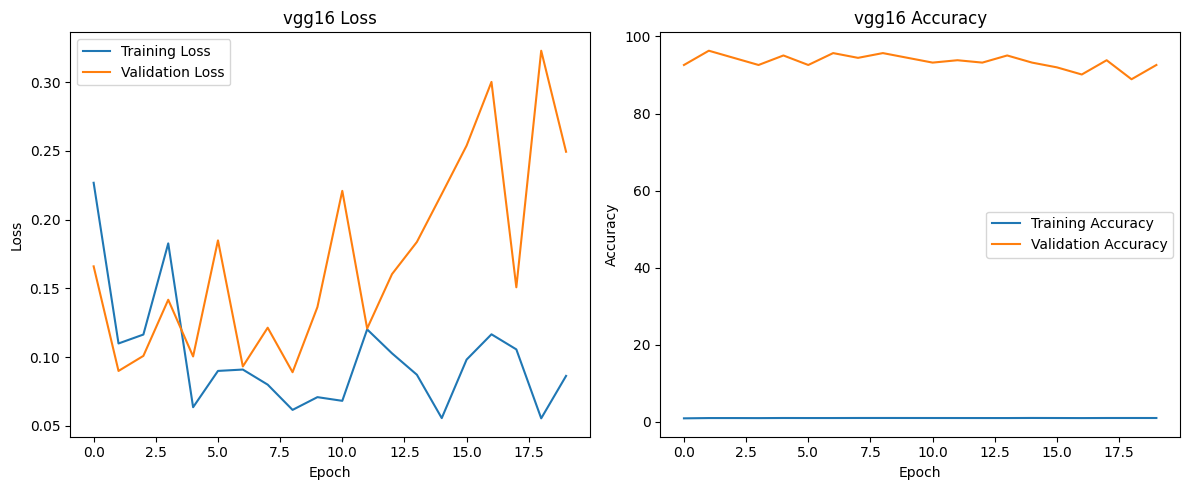

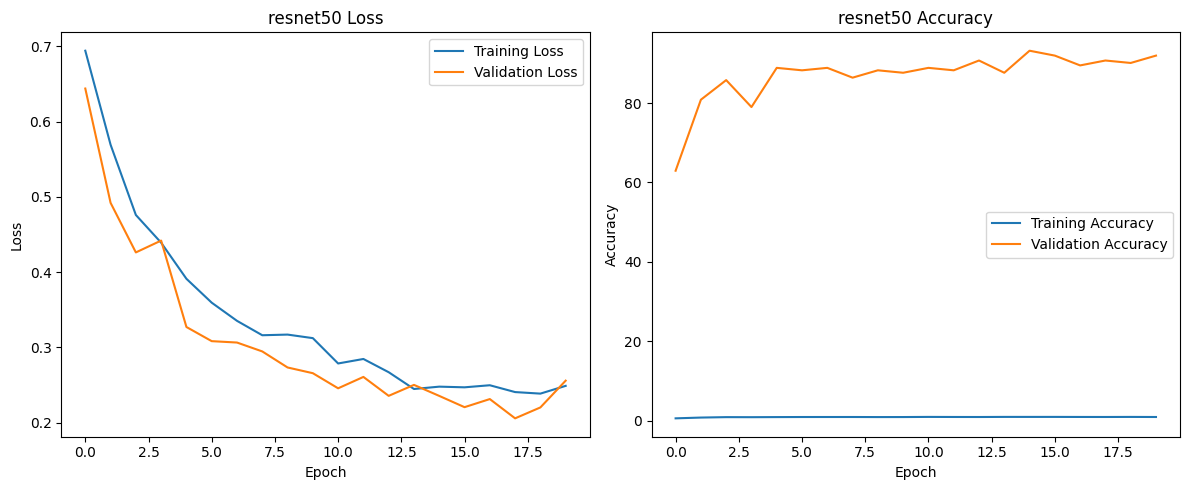

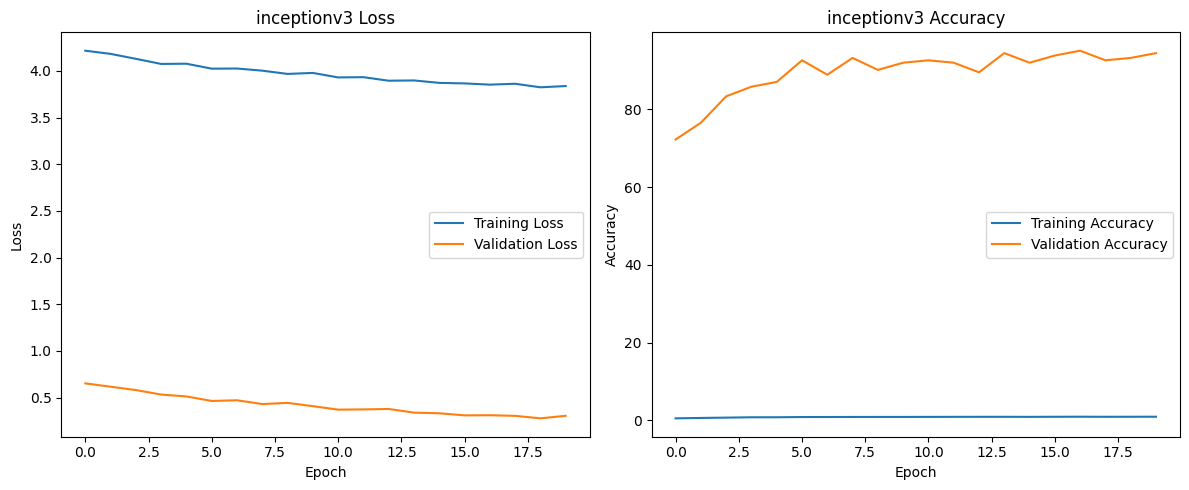

In [ ]:
# VISUALIZACIÓN DE RESULTADOS DE PERDIDA Y PRECISIÓN
import numpy as np
import matplotlib.pyplot as plt

def plot_history(history):
    for model_name, metrics in history.items():
        train_losses, train_accs, val_losses, val_accs = zip(*metrics)

        # Mover tensores a CPU y convertir a numpy si es necesario
        train_losses = np.array([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses])
        train_accs = np.array([acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_accs])
        val_losses = np.array([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses])
        val_accs = np.array([acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accs])

        plt.figure(figsize=(12, 5))

        # Pérdida
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Precisión
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Training Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Llama a la función con el historial
plot_history(history)


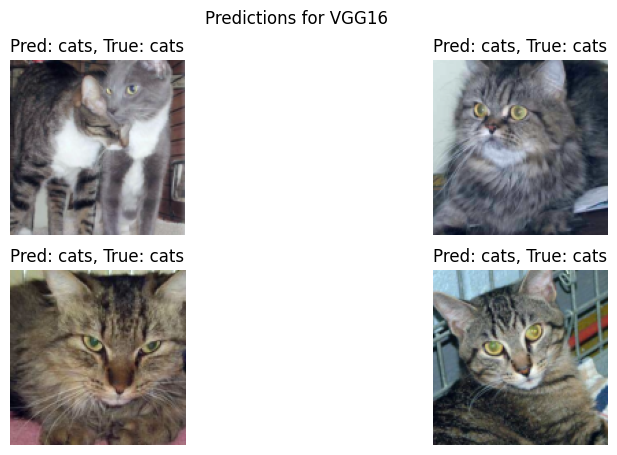

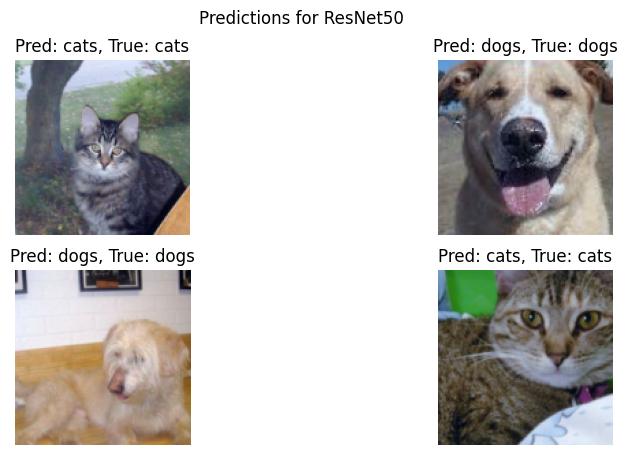

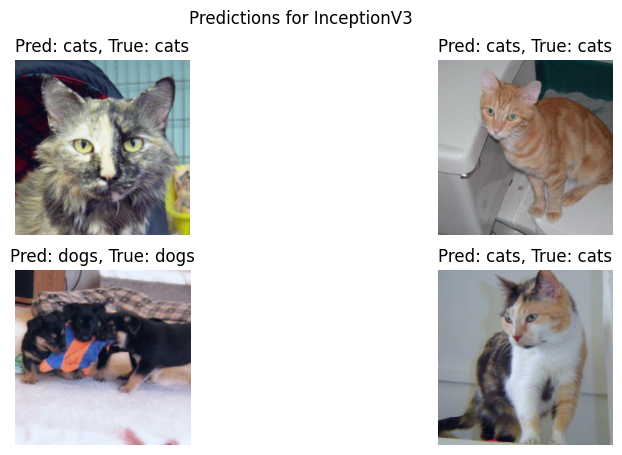

In [ ]:
# Función para hacer predicciones en imágenes aleatorias del conjunto de prueba
def make_predictions(model, test_loader, num_images=4):
    model.eval()

    # Obtener todos los datos del DataLoader
    all_images, all_labels = [], []
    for images, labels in test_loader:
        all_images.append(images)
        all_labels.append(labels)

    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Seleccionar índices aleatorios asegurando que tengamos clases mixtas
    indices = random.sample(range(len(all_images)), num_images)
    selected_images = all_images[indices]
    selected_labels = all_labels[indices]

    # Hacer predicciones
    with torch.no_grad():
        outputs = model(selected_images.to(device))
        _, preds = torch.max(outputs, 1)

    return selected_images, selected_labels, preds

# Mostrar imágenes correctamente
def display_predictions(model, test_loader, classes, title):
    selected_images, selected_labels, preds = make_predictions(model, test_loader)

    # Mostrar imágenes y sus predicciones
    plt.figure(figsize=(10, 5))
    for i in range(len(selected_images)):
        plt.subplot(2, 2, i + 1)
        # Normalizar la imagen para imshow
        img = selected_images[i].cpu().permute(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())  # Normalizar entre 0 y 1
        plt.imshow(img.numpy())
        plt.title(f"Pred: {classes[preds[i]]}, True: {classes[selected_labels[i]]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Definir las clases
classes = test_dataset_small.classes  # Usar las clases del dataset de prueba
classes1 = test_dataset_large.classes

# Hacer predicciones para cada modelo
display_predictions(vgg16, test_loader_small, classes, "Predictions for VGG16")
display_predictions(resnet50, test_loader_small, classes, "Predictions for ResNet50")
display_predictions(inceptionv3, test_loader_large, classes1, "Predictions for InceptionV3")